In [1]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split as tts
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
df = pd.read_csv('/content/drive/MyDrive/CSE440 Project/olid-training-v1.0.tsv', sep="\t")

In [4]:
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [5]:
X, y = df.tweet, df.subtask_a

In [6]:
X_train, X_valid, y_train, y_valid = tts(X, y, test_size = .2, random_state = 42)

In [7]:
X_train.to_csv('/content/drive/MyDrive/CSE440 Project/X_train.csv', index=False)
X_valid.to_csv('/content/drive/MyDrive/CSE440 Project/X_valid.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/CSE440 Project/y_train.csv', index=False)
y_valid.to_csv('/content/drive/MyDrive/CSE440 Project/y_valid.csv', index=False)

In [8]:
y_train.value_counts()

NOT    7107
OFF    3485
Name: subtask_a, dtype: int64

In [9]:
y_valid.value_counts()

NOT    1733
OFF     915
Name: subtask_a, dtype: int64

# Data Preprocessing

In [10]:
import string
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')
punctuations = list(string.punctuation)
stopword = list(stopwords.words('english'))
def preprocessingTraditionalLANG(d):
    tokens = word_tokenize(d)
    final_token = []
    x = WordNetLemmatizer()
    for token in tokens:
        if token not in punctuations:
            if token =='USER' or token == 'URL' or token.lower in stopword:
                #final_token.append(token)
                continue
            else:
                final_token.append(x.lemmatize(token.lower()))

    st = ' '.join(final_token)
    return st

def preprocessing_TRANSFORMER(d):
    tokens = word_tokenize(d)
    st = '[CLS] ' + ' '.join(tokens) + ' [SEP]'
    return st

def label_encoder(d):
    if 'N' in d: return 0
    else: return 1

def main():
    X_train = pd.read_csv('/content/drive/MyDrive/CSE440 Project/X_train.csv')
    X_valid = pd.read_csv('/content/drive/MyDrive/CSE440 Project/X_valid.csv')
    y_train = pd.read_csv('/content/drive/MyDrive/CSE440 Project/y_train.csv')
    y_valid = pd.read_csv('/content/drive/MyDrive/CSE440 Project/y_valid.csv')


    
    y_train.subtask_a = y_train.subtask_a.apply(label_encoder)
    y_valid.subtask_a = y_valid.subtask_a.apply(label_encoder)
    y_train.to_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trad/y_train.csv', index=False)
    y_valid.to_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trans/y_valid.csv', index=False)
    y_train.to_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trans/y_train.csv', index=False)
    y_valid.to_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trad/y_valid.csv', index=False)

    X_train['tweet'] = X_train.tweet.apply(preprocessingTraditionalLANG)
    X_valid['tweet'] = X_valid.tweet.apply(preprocessingTraditionalLANG)
    X_train.to_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trad/X_train_trad.csv', index=False)
    X_valid.to_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trad/X_valid_trad.csv', index=False)
    

    X_train = pd.read_csv('/content/drive/MyDrive/CSE440 Project/X_train.csv')
    X_valid = pd.read_csv('/content/drive/MyDrive/CSE440 Project/X_valid.csv')
    X_train['tweet'] = X_train.tweet.apply(preprocessing_TRANSFORMER)
    X_valid['tweet'] = X_valid.tweet.apply(preprocessing_TRANSFORMER)
    X_train.to_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trans/X_train_trans.csv', index=False)
    X_valid.to_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trans/X_valid_trans.csv', index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [11]:
main()

# LIN Feature 

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
from sklearn.svm import LinearSVC


def data_loader(X_train, y_train, X_valid, y_valid, n1, n2, tp = 'tfidf', feature_type=None):

    print(feature_type)
    if tp == 'tfidf':
        tfidf = TfidfVectorizer(ngram_range=(n1, n2), stop_words='english')
        x_train = tfidf.fit_transform(X_train.loc[:, 'tweet'].values)
        x_valid = tfidf.transform(X_valid.loc[:, 'tweet'].values)

        x_train = pd.DataFrame.sparse.from_spmatrix(x_train, columns = tfidf.get_feature_names_out())
        x_valid = pd.DataFrame.sparse.from_spmatrix(x_valid, columns = tfidf.get_feature_names_out())
        
        model = LinearSVC(max_iter=10000)
        model.fit(x_train, y_train.subtask_a)
        pred = model.predict(x_valid)
        cf = confusion_matrix(y_valid.subtask_a, pred)
        f1 = f1_score(y_valid.subtask_a, pred)
        print("Confusion Matrix")
        print(cf)
        print(f"F1 Score: {f1}")
        print(classification_report(y_valid.subtask_a, pred))

    elif tp=='cv':
        cv = CountVectorizer(ngram_range=(n1, n2), stop_words='english')
        x_train = cv.fit_transform(X_train.loc[:, 'tweet'].values)
        #x_test = cv.transform(x_test)
        x_valid = cv.transform(X_valid.loc[:, 'tweet'].values)

        x_train = pd.DataFrame.sparse.from_spmatrix(x_train, columns = cv.get_feature_names_out())
        x_valid = pd.DataFrame.sparse.from_spmatrix(x_valid, columns = cv.get_feature_names_out())

        
        model = LinearSVC(max_iter=10000)
        model.fit(x_train, y_train.subtask_a)
        pred = model.predict(x_valid)
        cf = confusion_matrix(y_valid.subtask_a, pred)
        f1 = f1_score(y_valid.subtask_a, pred)
        print("Confusion Matrix")
        print(cf)
        print(f"F1 Score: {f1}")
        print(classification_report(y_valid.subtask_a, pred))
        #x_test.to_csv(f'/content/drive/MyDrive/CSE440 Project/X_test_cv_{n1}-{n2}_gram.csv')
    

def u_tfidf(X_train, y_train, X_valid, y_valid):
    data_loader(X_train, y_train, X_valid, y_valid, 1,1,'tfidf', 'u_tfidf')

def bi_tfidf(X_train, y_train, X_valid, y_valid):
    data_loader(X_train, y_train, X_valid, y_valid, 2,2, 'tfidf', 'bi_tfidf')

def tri_tfidf(X_train, y_train, X_valid, y_valid):
    data_loader(X_train, y_train, X_valid, y_valid, 3,3, 'tfidf', 'tri_tfidf')

def u_bi_tfidf(X_train, y_train, X_valid, y_valid):
    data_loader(X_train, y_train, X_valid, y_valid, 1,2, 'tfidf', 'u_bi_tfidf')

def bi_tri_tfidf(X_train, y_train, X_valid, y_valid):
    data_loader(X_train, y_train, X_valid, y_valid, 2,3, 'tfidf', 'bi_tri_tfidf')

def u_bi_tri_tfidf(X_train, y_train, X_valid, y_valid):
    data_loader(X_train, y_train, X_valid, y_valid, 1,3, 'tfidf', 'u_bi_tri_tfidf')


def u_cv(X_train, y_train, X_valid, y_valid):
    data_loader(X_train, y_train, X_valid, y_valid, 1,1, 'cv', 'u_cv')

def bi_cv(X_train, y_train, X_valid, y_valid):
    data_loader(X_train, y_train, X_valid, y_valid, 2,2, 'cv', 'bi_cv')

def tri_cv(X_train, y_train, X_valid, y_valid):
    data_loader(X_train, y_train, X_valid, y_valid, 3,3, 'cv', 'tri_cv')

def u_bi_cv(X_train, y_train, X_valid, y_valid):
    data_loader(X_train, y_train, X_valid, y_valid, 1,2, 'cv', 'u_bi_cv')

def bi_tri_cv(X_train, y_train, X_valid, y_valid):
    data_loader(X_train, y_train, X_valid, y_valid, 2, 3, 'cv', 'bi_tri_cv')

def u_bi_tri_cv(X_train, y_train, X_valid, y_valid):
    data_loader(X_train, y_train, X_valid, y_valid, 1,3, 'cv', 'u_bi_tri_cv')


def main():
    X_train_trad = pd.read_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trad/X_train_trad.csv')
    X_valid_trad = pd.read_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trad/X_valid_trad.csv')
    y_train = pd.read_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trad/y_train.csv')
    y_valid = pd.read_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trad/y_valid.csv')
    
    u_tfidf(X_train_trad, y_train, X_valid_trad, y_valid)
    bi_tfidf(X_train_trad, y_train, X_valid_trad, y_valid)
    tri_tfidf(X_train_trad, y_train, X_valid_trad, y_valid)
    u_bi_tfidf(X_train_trad, y_train, X_valid_trad, y_valid)
    bi_tri_tfidf(X_train_trad, y_train, X_valid_trad, y_valid)
    u_bi_tri_tfidf(X_train_trad, y_train, X_valid_trad, y_valid)

    u_cv(X_train_trad, y_train, X_valid_trad, y_valid)
    bi_cv(X_train_trad, y_train, X_valid_trad, y_valid)
    tri_cv(X_train_trad, y_train, X_valid_trad, y_valid)
    u_bi_cv(X_train_trad, y_train, X_valid_trad, y_valid)
    bi_tri_cv(X_train_trad, y_train, X_valid_trad, y_valid)
    u_bi_tri_cv(X_train_trad, y_train, X_valid_trad, y_valid)



In [13]:
main()

u_tfidf
Confusion Matrix
[[1520  213]
 [ 426  489]]
F1 Score: 0.6048237476808905
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1733
           1       0.70      0.53      0.60       915

    accuracy                           0.76      2648
   macro avg       0.74      0.71      0.72      2648
weighted avg       0.75      0.76      0.75      2648

bi_tfidf
Confusion Matrix
[[1599  134]
 [ 763  152]]
F1 Score: 0.2531223980016653
              precision    recall  f1-score   support

           0       0.68      0.92      0.78      1733
           1       0.53      0.17      0.25       915

    accuracy                           0.66      2648
   macro avg       0.60      0.54      0.52      2648
weighted avg       0.63      0.66      0.60      2648

tri_tfidf
Confusion Matrix
[[1703   30]
 [ 889   26]]
F1 Score: 0.053553038105046344
              precision    recall  f1-score   support

           0       0.66      0.98      0.79

# Bi-LSTM

Thanks to Niloy Farhan and https://github.com/shabbirg89/Youtube-2021/blob/main/Multiclass_Text_Classifier_LSTM.ipynb

In [32]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.8.0
Running on TPU  ['10.124.153.82:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.124.153.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.153.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import string
import nltk
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Embedding, LSTM,SpatialDropout1D, Dropout, Bidirectional, Conv2D
from keras.utils.np_utils import to_categorical
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')
punctuations = list(string.punctuation)
stopword = list(stopwords.words('english'))

def preprocessingTraditionalLANG(d):
    tokens = word_tokenize(d)
    final_token = []
    x = WordNetLemmatizer()
    for token in tokens:
        if token not in punctuations:
            if token =='USER' or token == 'URL' or token.lower in stopword:
                #final_token.append(token)
                continue
            else:
                final_token.append(x.lemmatize(token.lower()))

    st = ' '.join(final_token)
    return st


def label_encoder(d):
    if 'N' in d: return 0
    else: return 1

def main():
    # X_test = pd.read_csv('/content/drive/MyDrive/CSE440 Project/testset-levela.tsv', sep = '\t')
    # y_test = pd.read_csv('/content/drive/MyDrive/CSE440 Project/labels-levela.csv')
    # y_test.OFF = y_test.OFF.apply(label_encoder)
    # X_test['tweet'] = X_test.tweet.apply(preprocessingTraditionalLANG)
    
    # X_train = pd.read_csv('/content/drive/MyDrive/CSE440 Project/X_train.csv')
    # X_valid = pd.read_csv('/content/drive/MyDrive/CSE440 Project/X_valid.csv')
    # y_train = pd.read_csv('/content/drive/MyDrive/CSE440 Project/y_train.csv')
    # y_valid = pd.read_csv('/content/drive/MyDrive/CSE440 Project/y_valid.csv')

    df = pd.read_csv('/content/drive/MyDrive/CSE440 Project/olid-training-v1.0.tsv', sep='\t')
    df.subtask_a = df.subtask_a.apply(label_encoder)
    y = df.subtask_a
    # Took this code snippet from https://github.com/shabbirg89/Youtube-2021/blob/main/Multiclass_Text_Classifier_LSTM.ipynb
    maxWord = 10000
    maxSeqLength = 120
    EMBEDDING_DIM = 300
    punctuations = string.punctuation

    tokenizer = Tokenizer(num_words=maxWord, filters=punctuations, lower=True)
    tokenizer.fit_on_texts(df['tweet'].values)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    X = tokenizer.texts_to_sequences(df['tweet'].values)
    X = pad_sequences(X, maxlen=maxSeqLength)
    print('Shape of data tensor:', X.shape)
    y = pd.get_dummies(y).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)
    print(X_train.shape,y_train.shape)
    print(X_test.shape,y_test.shape)


    # Own Architeucture 
    with tpu_strategy.scope():
        model = Sequential()
        model.add(Embedding(maxWord, EMBEDDING_DIM, input_length=X.shape[1]))
        model.add(Bidirectional(LSTM(300, dropout=0.2, recurrent_dropout=0.2)))
        model.add(Dense(512, activation='softmax'))
        model.add(Dense(256, activation='softmax'))
        model.add(Dropout(0.2))
        model.add(Dense(128, activation='softmax'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='softmax'))
        model.add(Dropout(0.2))
        model.add(Dense(2, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    epochs = 150
    batch_size = 64*tpu_strategy.num_replicas_in_sync
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])
    accr = model.evaluate(X_test,y_test)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
    return model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
model = main()

Found 20790 unique tokens.
Shape of data tensor: (13240, 120)
(11916, 120) (11916, 2)
(1324, 120) (1324, 2)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 120, 300)          3000000   
                                                                 
 bidirectional_11 (Bidirecti  (None, 600)              1442400   
 onal)                                                           
                                                                 
 dense_36 (Dense)            (None, 512)               307712    
                                                                 
 dense_37 (Dense)            (None, 256)               131328    
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_38 (D

# Hybrid model

My old work https://github.com/quaziadib/A-Deep-Hybrid-Learning-to-Detect-Bangla-Fake-News

In [15]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


X_train, X_test, y_train, y_test = pd.read_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trans/X_train_trans.csv'), pd.read_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trans/X_valid_trans.csv'), pd.read_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trans/y_train.csv'), pd.read_csv('/content/drive/MyDrive/CSE440 Project/Preprocessing_Trans/y_valid.csv')
X_train = X_train.tweet.values
X_test = X_test.tweet.values

y_train = y_train.subtask_a.values
y_test = y_test.subtask_a.values

def createModel():
    model = keras.Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(256, 5, activation='relu'))
    model.add(layers.MaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='softmax'))
    return model

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

puncList = ["।", "”", "“", "’"]
x = "".join(puncList)
filterString = x + '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n০১২৩৪৫৬৭৮৯'
tokenizer = Tokenizer(filters=filterString, lower=False,oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index)+1
maxlen = 800
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
    
embedding_dim = 100
model = createModel()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_metric])
history = model.fit(X_train, y_train,epochs=10, batch_size=64)
model = keras.Model(inputs = model.inputs, outputs = [model.layers[-2].output])


    
X_train = model.predict(X_train)
X_test = model.predict(X_test)


X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)


Epoch 1/10
166/166 [==============================] - 9s 33ms/step - loss: 0.6152 - f1_metric: 0.4906
Epoch 2/10
166/166 [==============================] - 6s 37ms/step - loss: 0.3636 - f1_metric: 0.4919
Epoch 3/10
166/166 [==============================] - 6s 37ms/step - loss: 0.1135 - f1_metric: 0.4918
Epoch 4/10
166/166 [==============================] - 6s 37ms/step - loss: 0.0315 - f1_metric: 0.4917
Epoch 5/10
166/166 [==============================] - 6s 36ms/step - loss: 0.0175 - f1_metric: 0.4927
Epoch 6/10
166/166 [==============================] - 6s 36ms/step - loss: 0.0080 - f1_metric: 0.4922
Epoch 7/10
166/166 [==============================] - 6s 35ms/step - loss: 0.0043 - f1_metric: 0.4917
Epoch 8/10
166/166 [==============================] - 6s 35ms/step - loss: 0.0037 - f1_metric: 0.4933
Epoch 9/10
166/166 [==============================] - 5s 32ms/step - loss: 0.0031 - f1_metric: 0.4923
Epoch 10/10
166/166 [==============================] - 5s 32ms/step - loss: 0.0024

----------
SVC


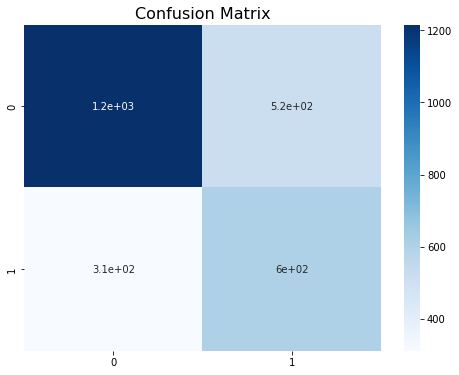

True: {'precision': 0.5388046387154326, 'recall': 0.6601092896174864, 'f1-score': 0.593320235756385, 'support': 915}
Fake: {'precision': 0.796332678454486, 'recall': 0.7016733987305251, 'f1-score': 0.7460122699386504, 'support': 1733}
Overall: {'Accuracy': 0.6873111782477341, 'recall': 0.6601092896174864, 'f1-score': 0.593320235756385, 'precision': 0.5388046387154326}
----------
RandomForestClassifier


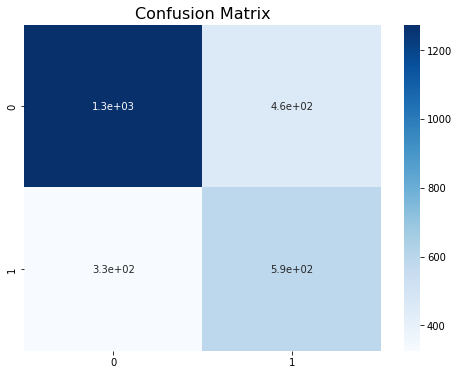

True: {'precision': 0.5620229007633588, 'recall': 0.6437158469945355, 'f1-score': 0.6001018848700967, 'support': 915}
Fake: {'precision': 0.79625, 'recall': 0.7351413733410271, 'f1-score': 0.7644764476447645, 'support': 1733}
Overall: {'Accuracy': 0.7035498489425982, 'recall': 0.6437158469945355, 'f1-score': 0.6001018848700967, 'precision': 0.5620229007633588}
----------
DecisionTreeClassifier


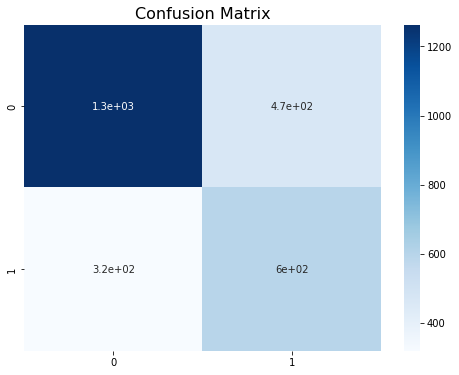

True: {'precision': 0.5590994371482176, 'recall': 0.6513661202185792, 'f1-score': 0.601716304896517, 'support': 915}
Fake: {'precision': 0.7983565107458913, 'recall': 0.7287939988459319, 'f1-score': 0.7619909502262443, 'support': 1733}
Overall: {'Accuracy': 0.7020392749244713, 'recall': 0.6513661202185792, 'f1-score': 0.601716304896517, 'precision': 0.5590994371482176}
----------
AdaBoostClassifier


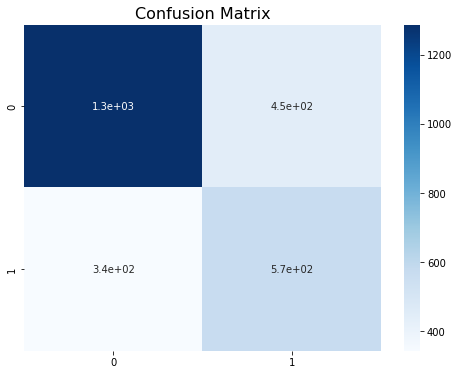

True: {'precision': 0.5614552605703048, 'recall': 0.6240437158469946, 'f1-score': 0.5910973084886129, 'support': 915}
Fake: {'precision': 0.789086450030656, 'recall': 0.7426428159261397, 'f1-score': 0.7651605231866826, 'support': 1733}
Overall: {'Accuracy': 0.7016616314199395, 'recall': 0.6240437158469946, 'f1-score': 0.5910973084886129, 'precision': 0.5614552605703048}
----------
KNN


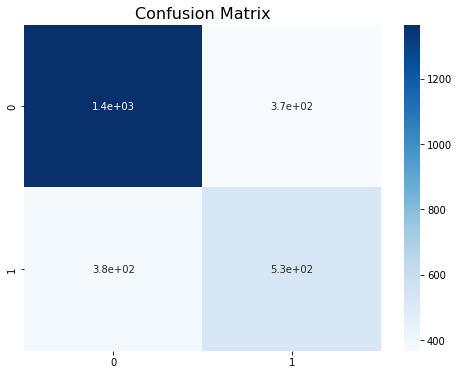

True: {'precision': 0.5908584169453734, 'recall': 0.5792349726775956, 'f1-score': 0.5849889624724062, 'support': 915}
Fake: {'precision': 0.7801256424900057, 'recall': 0.7882285054818234, 'f1-score': 0.7841561423650976, 'support': 1733}
Overall: {'Accuracy': 0.716012084592145, 'recall': 0.5792349726775956, 'f1-score': 0.5849889624724062, 'precision': 0.5908584169453734}


In [16]:
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
# import pickle

print('-'*10)
print('SVC')
svc = LinearSVC()
svc.fit(X_train, y_train)
preds = svc.predict(X_test)
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()
report = classification_report(y_test, preds, output_dict=True)
true = report['1']
fake = report['0']
overall = {"Accuracy": accuracy_score(y_test, preds), "recall": recall_score(y_test, preds),
               "f1-score": f1_score(y_test, preds), "precision": precision_score(y_test, preds) }

# model_path = "saved_models/svc_det_only.pkl"
# pickle.dump(svc, open(model_path, 'wb'))
    
print("True:", true)
print("Fake:", fake)
print("Overall:", overall)

# X_train = pd.read_csv('XTrain.csv')
# X_test = pd.read_csv('XTest.csv')
# y_train = pd.read_csv('ytrain.csv')
# y_test = pd.read_csv('ytest.csv')


print('-'*10)
print('RandomForestClassifier')
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()
report = classification_report(y_test, preds, output_dict=True)
true = report['1']
fake = report['0']
overall = {"Accuracy": accuracy_score(y_test, preds), "recall": recall_score(y_test, preds),
               "f1-score": f1_score(y_test, preds), "precision": precision_score(y_test, preds) }

# # model_path = "saved_models/random_forest_det_only.pkl"
# # pickle.dump(rfc, open(model_path, 'wb'))

print("True:", true)
print("Fake:", fake)
print("Overall:", overall)
      
    
print('-'*10)
print('DecisionTreeClassifier')
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
preds = dtc.predict(X_test)
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()
report = classification_report(y_test, preds, output_dict=True)
true = report['1']
fake = report['0']
overall = {"Accuracy": accuracy_score(y_test, preds), "recall": recall_score(y_test, preds),
               "f1-score": f1_score(y_test, preds), "precision": precision_score(y_test, preds) }

# # model_path = "saved_models/decision_tree_det_only.pkl"
# # pickle.dump(dtc, open(model_path, 'wb'))
    
print("True:", true)
print("Fake:", fake)
print("Overall:", overall)

  
print('-'*10)
print('AdaBoostClassifier')
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
preds = abc.predict(X_test)
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()
report = classification_report(y_test, preds, output_dict=True)
true = report['1']
fake = report['0']
overall = {"Accuracy": accuracy_score(y_test, preds), "recall": recall_score(y_test, preds),
               "f1-score": f1_score(y_test, preds), "precision": precision_score(y_test, preds) }

# model_path = "saved_models/ada_boosting_det_only.pkl"
# pickle.dump(abc, open(model_path, 'wb'))

print("True:", true)
print("Fake:", fake)
print("Overall:", overall)
  

    

print('-'*10)
print('KNN')
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)
prec = precision_score(y_test, preds)
f1score = f1_score(y_test, preds)

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()
report = classification_report(y_test, preds, output_dict=True)
true = report['1']
fake = report['0']

overall = {"Accuracy": accuracy_score(y_test, preds), "recall": recall_score(y_test, preds),
               "f1-score": f1_score(y_test, preds), "precision": precision_score(y_test, preds) }

# model_path = "saved_models/knn_det_only.pkl"
# pickle.dump(knn, open(model_path, 'wb'))
    
print("True:", true)
print("Fake:", fake)
print("Overall:", overall)
